# RSM8413: Case 1

#### Team 15: Joanne Chien, Harsh Pinge, Venkata Surya Sai Nikhil Garimella, Sharon Xiao, Jitao Zhang

In [92]:
# Required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import altair as alt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

## 1. Cleaning the dataset

### 1.1 First glimpse of the dataset

In [93]:
ebay_raw = pd.read_excel("data/ebayAuctions.xlsx", sheet_name = "eBay auctions")
ebay_raw.head()

,Category,Currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0


In [94]:
ebay_raw.shape

(1972, 8)

In [95]:
ebay_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Category      1972 non-null   object 
 1   Currency      1972 non-null   object 
 2   sellerRating  1972 non-null   int64  
 3   Duration      1972 non-null   int64  
 4   endDay        1972 non-null   object 
 5   ClosePrice    1972 non-null   float64
 6   OpenPrice     1972 non-null   float64
 7   Competitive?  1972 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 123.4+ KB


In [96]:
ebay_raw.describe()

,sellerRating,Duration,ClosePrice,OpenPrice,Competitive?
count,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000
mean,3560.238337,6.486308,36.449087,12.926268,0.540568
std,5973.011033,2.052906,89.493858,38.856149,0.498478
min,0.000000,1.000000,0.010000,0.010000,0.000000
25%,595.000000,5.000000,4.907500,1.230000,0.000000
50%,1853.000000,7.000000,9.995000,4.500000,1.000000
75%,3380.000000,7.000000,28.000000,9.990000,1.000000
max,37727.000000,10.000000,999.000000,999.000000,1.000000


In [97]:
ebay_raw['Category'].value_counts()

Category
Music/Movie/Game        403
Collectibles            239
Toys/Hobbies            234
Automotive              178
Antique/Art/Craft       177
SportingGoods           124
Clothing/Accessories    119
Home/Garden             102
Jewelry                  82
Health/Beauty            64
Electronics              55
Books                    54
Coins/Stamps             37
Computer                 36
Pottery/Glass            20
Business/Industrial      18
EverythingElse           17
Photography              13
Name: count, dtype: int64

In [98]:
ebay_raw['Currency'].value_counts()

Currency
US     1292
EUR     533
GBP     147
Name: count, dtype: int64

In [99]:
ebay_raw['endDay'].value_counts()

endDay
Mon    548
Sat    351
Sun    338
Fri    287
Thu    202
Tue    171
Wed     75
Name: count, dtype: int64

### 1.2 Initial Cleanings

In [100]:
# Rename the response column and format all other variable names
ebay = ebay_raw.rename(columns={'Competitive?': 'Competitive',
                                'sellerRating': 'SellerRating',
                                'endDay': 'EndDay'})
ebay.head()

,Category,Currency,SellerRating,Duration,EndDay,ClosePrice,OpenPrice,Competitive
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0


In [101]:
# convert all prices into USD (preparation)
eur_to_usd = 1.2076
gbp_to_usd = 1.8080

def convert_fx(row):
    if row['Currency'] == 'EUR':
        row['ClosePrice'] *= eur_to_usd
        row['OpenPrice'] *= eur_to_usd
    elif row['Currency'] == 'GBP':
        row['ClosePrice'] *= gbp_to_usd
        row['OpenPrice'] *= gbp_to_usd
    return row

In [102]:
# convert all prices into USD (continue) & get rid of the currency column
ebay = ebay.apply(convert_fx, axis = 1)
ebay['ClosePrice'] = ebay['ClosePrice'].round(2)
ebay['OpenPrice'] = ebay['OpenPrice'].round(2)

ebay = ebay.drop(columns=['Currency'])

In [103]:
ebay.tail(10)

,Category,SellerRating,Duration,EndDay,ClosePrice,OpenPrice,Competitive
1962,Automotive,0,10,Sun,590.00,99.00,1
1963,Automotive,4,10,Sun,943.00,148.50,1
1964,SportingGoods,1,7,Fri,417.99,200.00,1
1965,Automotive,97,3,Fri,290.00,290.00,0
1966,Automotive,142,7,Sat,521.55,200.00,1
1967,Automotive,2992,5,Sun,359.95,359.95,0
1968,Automotive,21,5,Sat,610.00,300.00,1
1969,Automotive,1400,5,Mon,549.00,549.00,0
1970,Automotive,57,7,Fri,820.00,650.00,1
1971,Automotive,145,7,Sat,999.00,999.00,0


In [104]:
ebay.describe()

,SellerRating,Duration,ClosePrice,OpenPrice,Competitive
count,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000
mean,3560.238337,6.486308,39.405147,13.574544,0.540568
std,5973.011033,2.052906,95.610641,39.410893,0.498478
min,0.000000,1.000000,0.010000,0.010000,0.000000
25%,595.000000,5.000000,4.990000,1.490000,0.000000
50%,1853.000000,7.000000,11.145000,4.990000,1.000000
75%,3380.000000,7.000000,30.960000,11.015000,1.000000
max,37727.000000,10.000000,1042.500000,999.000000,1.000000


## 2. EDA

### 2.1 Proportion of competitive in each category

In [105]:
category_counts = ebay.groupby(['Category', 'Competitive']).size().reset_index(name='count')
category_counts['total'] = category_counts.groupby('Category')['count'].transform('sum')
category_counts['proportion'] = category_counts['count'] / category_counts['total']

chart = alt.Chart(category_counts).mark_bar().encode(
    x = alt.X('Category:N', title = 'Category'),
    y = alt.Y('proportion:Q', title = 'Proportion'),
    color = alt.Color('Competitive:N', title = 'Competitive'),
    tooltip = alt.Tooltip('proportion:Q', title = 'Proportion')
).properties(
    title='Standardized Competitive Distribution by Category'
)

chart.show()

alt.Chart(...)

### 2.2 Facet plots of OpenPrice vs ClosePrice

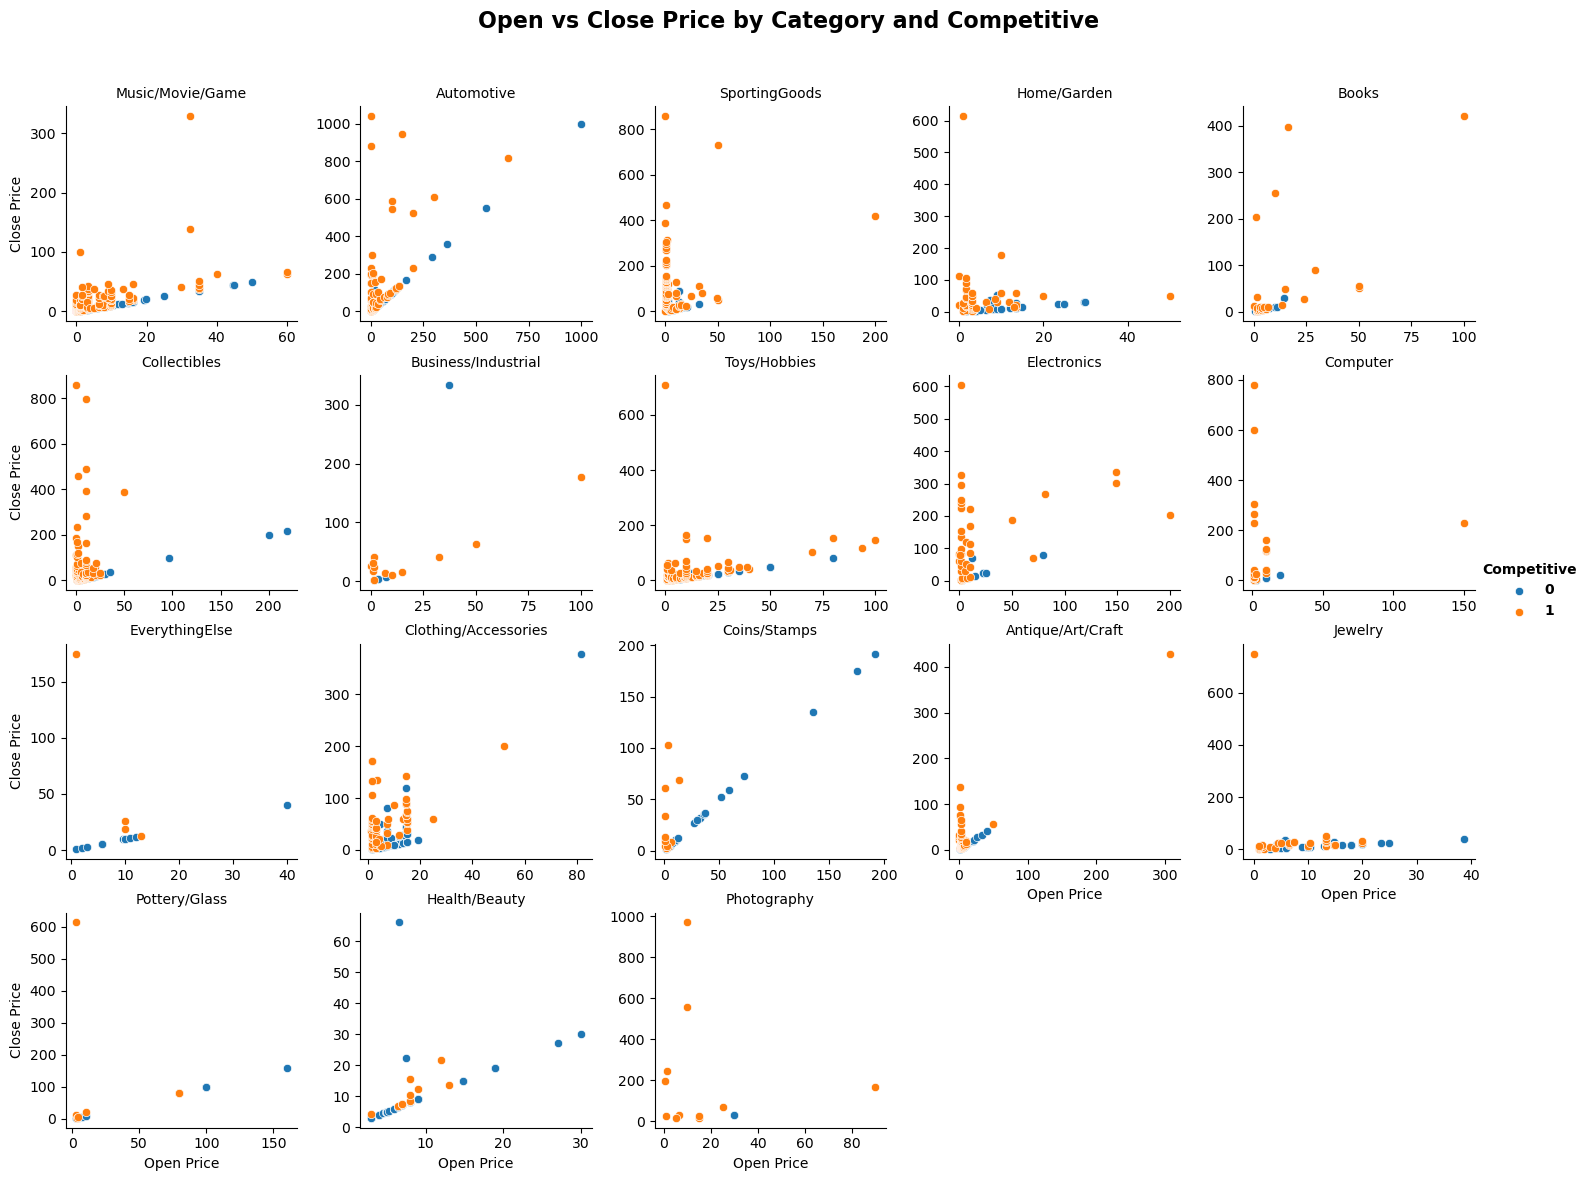

In [106]:
grid = sns.FacetGrid(
    ebay,
    col = 'Category',
    col_wrap = 5,               # 5 plots per row
    hue = 'Competitive',        # Color by competitive label
    height = 3,                 # Size of each subplot
    sharex = False,
    sharey = False
)

grid.map_dataframe(sns.scatterplot, x = 'OpenPrice', y = 'ClosePrice')
grid.add_legend(title = 'Competitive')
grid.set_axis_labels('Open Price', 'Close Price')
grid.set_titles(col_template = '{col_name}')

plt.subplots_adjust(top = 0.9)
plt.suptitle('Open vs Close Price by Category and Competitive',
             fontsize = 16,
             fontweight = 'bold')

legend = grid._legend
plt.setp(legend.get_texts(), fontweight = 'bold')
plt.setp(legend.get_title(), fontweight = 'bold')

plt.show()

### 2.3 Histogram for Standardized Competitive Distribution by Auction End Day

Text(0, 0.5, 'Proportion')

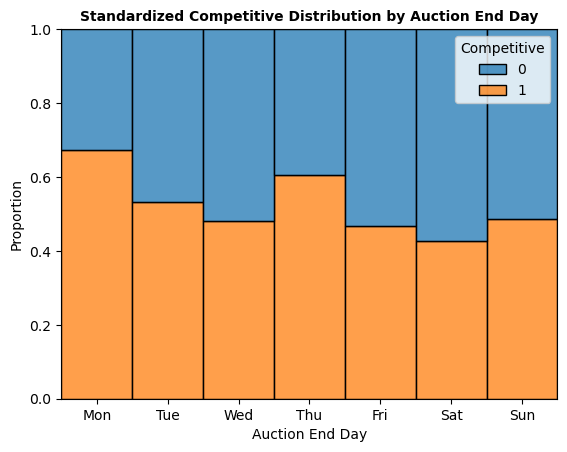

In [107]:
# gemini used for first two lines: 
endday_order = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"] 
ebay["EndDay"] = pd.Categorical( ebay["EndDay"], categories=endday_order, ordered=True )
ax = sns.histplot(x="EndDay", hue="Competitive", discrete=True, multiple="fill", data=ebay)
ax.set_title("Standardized Competitive Distribution by Auction End Day", fontsize=10, fontweight='bold')
ax.set_xlabel("Auction End Day", fontsize=10)
ax.set_ylabel("Proportion", fontsize=10)

### 2.4 Histogram for Standardized Competitive Distribution by Auction Duration

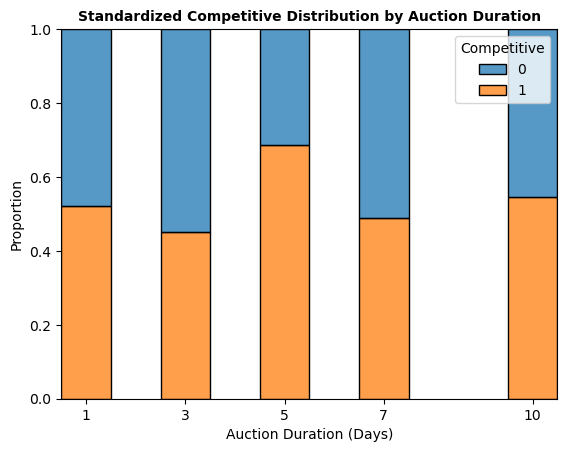

In [108]:
ax = sns.histplot(x="Duration", hue="Competitive", discrete=True, multiple="fill", data=ebay)
ax.set_title("Standardized Competitive Distribution by Auction Duration", fontsize=10, fontweight='bold')
ax.set_xlabel("Auction Duration (Days)", fontsize=10)
ax.set_ylabel("Proportion", fontsize=10)

# gemini used for these two lines here
ax.set_xticks([1,3,5,7,10])
ax.set_xticklabels([1,3,5,7,10])
legend = ax.get_legend()
legend.set_bbox_to_anchor((1,1))
legend.set_loc('upper right')

### 2.5 Correlation Heatmap for Quantitative Predictors and Response

Text(0.5, 1.0, 'Correlation Heatmap for Quantitative Predictors and Response')

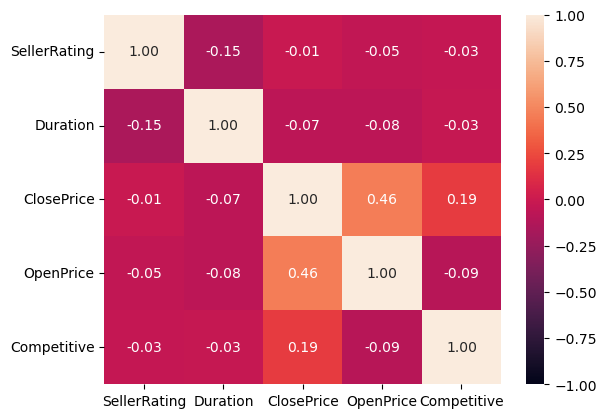

In [109]:
ebay_corr = ebay.drop(columns=['Category','EndDay'])
sns.heatmap(ebay_corr.corr(method='pearson'),annot=True,fmt=".2f",vmin=-1,vmax=1)
ax.set_title("Correlation Heatmap for Quantitative Predictors and Response", fontsize=14, pad=10)

### 2.6 Interactions among Numerical Variables Colored by Competitiveness (optional)

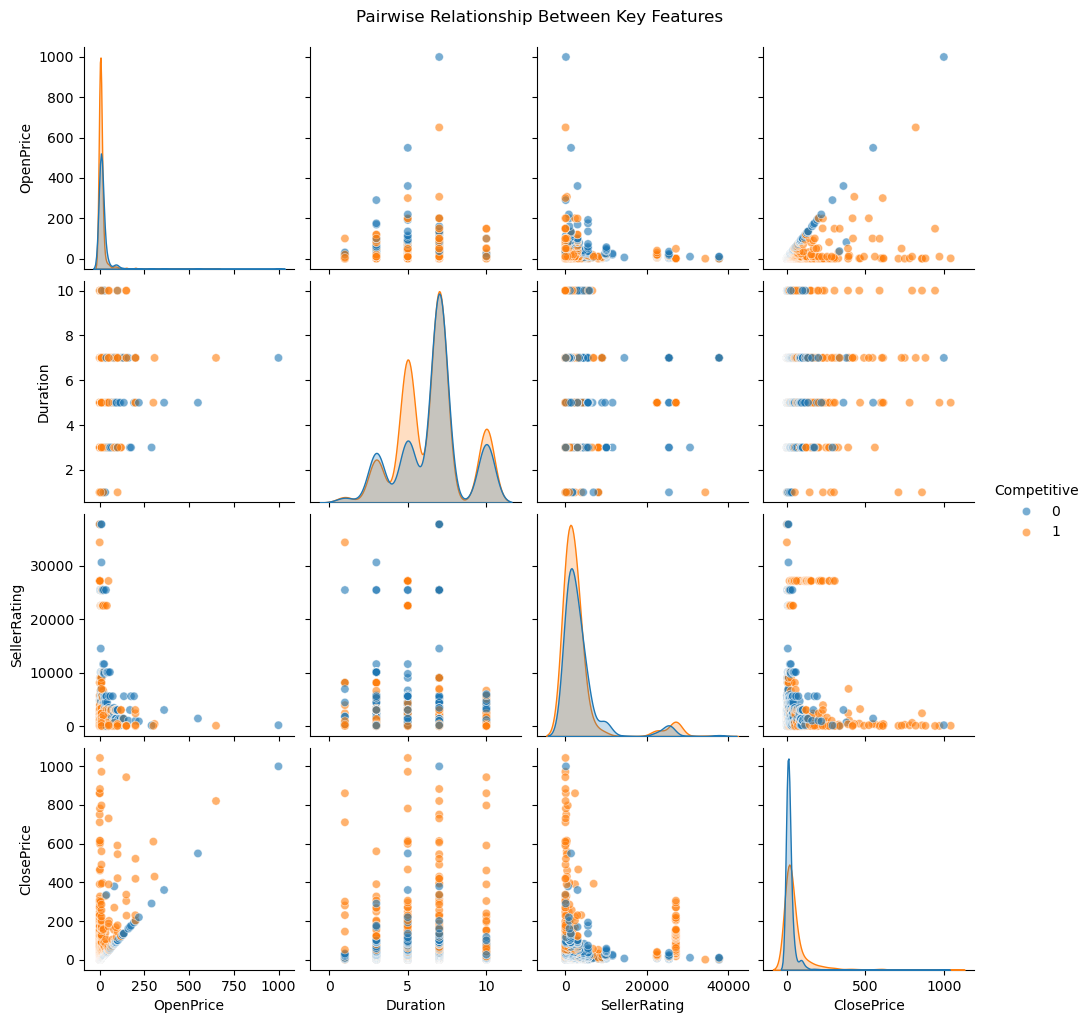

In [110]:
sns.pairplot(ebay, 
             vars=["OpenPrice", "Duration", "SellerRating", "ClosePrice"],
             hue="Competitive", 
             diag_kind="kde", 
             palette={0: "#1f77b4", 1: "#ff7f0e"}, 
             plot_kws={'alpha':0.6})
plt.suptitle("Pairwise Relationship Between Key Features", y=1.02)
plt.show()

## 3. Other Set-ups before fitting the models

### 3.1 Set up the scoring metric and folds that will be used for CV

In [111]:
# accuracy will be our chosen accuracy throughout this project
scoring_metric = "accuracy"

# folds that we will be using for CV
num_folds = 10

### 3.2 Spliting the data

In [112]:
train_df, test_df = train_test_split(ebay, test_size = 0.3, random_state = 8413)

X_train = train_df.drop(columns = ['Competitive'])
y_train = train_df['Competitive']
X_test = test_df.drop(columns = ['Competitive'])
y_test = test_df['Competitive']

print(X_train.shape)
print(X_test.shape)

(1380, 6)
(592, 6)


### 3.3 Building the General Data Cleaning Pipeline

In [113]:
numeric_features = ["SellerRating",
                    "Duration",
                    "ClosePrice",
                    "OpenPrice"]
categorical_features = ["Category",
                        "EndDay"]


In [114]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output = False)

In [115]:
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features)
)

preprocessor

,transformers,"[('standardscaler', ...), ('onehotencoder', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


## 4. KNN

### 4.1 KNN Using All Available Predictors in the Cleaned Dataset

#### Step 1: Scale X variables

In [116]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

#### Step 2: KNN and Cross Validation

In [117]:
model = KNeighborsClassifier()
kfold = KFold(n_splits = num_folds, shuffle = True, random_state = 8413)

In [118]:
cv_results = cross_val_score(model, X_train_transformed, y_train, cv = kfold, scoring = scoring_metric)
msg = "KNN: %f (%f)" % (cv_results.mean(), cv_results.std())

print(msg)
print(cv_results)

KNN: 0.731884 (0.034752)
[0.78985507 0.74637681 0.76086957 0.71014493 0.69565217 0.6884058
 0.73913043 0.73913043 0.68115942 0.76811594]


In [119]:
# Grid search
k_values = np.arange(1,22)

param_grid = dict(n_neighbors = k_values)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = scoring_metric, cv = kfold)
grid_results = grid.fit(X_train_transformed, y_train)

print("Best: %f using %s" % (grid_results.best_score_, grid_results.best_params_))

Best: 0.748551 using {'n_neighbors': np.int64(1)}


In [120]:
# Show all grid search results
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

0.748551 (0.025321) with: {'n_neighbors': np.int64(1)}
0.728986 (0.025966) with: {'n_neighbors': np.int64(2)}
0.720290 (0.038235) with: {'n_neighbors': np.int64(3)}
0.731884 (0.039291) with: {'n_neighbors': np.int64(4)}
0.731884 (0.034752) with: {'n_neighbors': np.int64(5)}
0.720290 (0.034933) with: {'n_neighbors': np.int64(6)}
0.723913 (0.038269) with: {'n_neighbors': np.int64(7)}
0.719565 (0.038624) with: {'n_neighbors': np.int64(8)}
0.721739 (0.035083) with: {'n_neighbors': np.int64(9)}
0.707971 (0.048290) with: {'n_neighbors': np.int64(10)}
0.707971 (0.029710) with: {'n_neighbors': np.int64(11)}
0.706522 (0.027162) with: {'n_neighbors': np.int64(12)}
0.706522 (0.023648) with: {'n_neighbors': np.int64(13)}
0.704348 (0.022405) with: {'n_neighbors': np.int64(14)}
0.708696 (0.014420) with: {'n_neighbors': np.int64(15)}
0.698551 (0.021787) with: {'n_neighbors': np.int64(16)}
0.693478 (0.019186) with: {'n_neighbors': np.int64(17)}
0.704348 (0.021447) with: {'n_neighbors': np.int64(18)}
0

Text(0, 0.5, 'Accuracy')

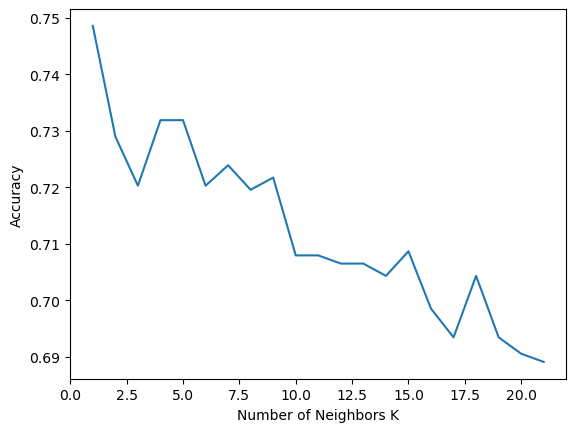

In [121]:
plt.plot(k_values, means)
plt.xlabel("Number of Neighbors K")
plt.ylabel("Accuracy")

#### Step 3: Results on Test Data

In [122]:
model = KNeighborsClassifier(n_neighbors = 1)
model.fit(X_train_transformed, y_train)
estimates = model.predict(X_test_transformed)

print(accuracy_score(y_test, estimates))
model.get_params()

0.7787162162162162


{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 1,
 'p': 2,
 'weights': 'uniform'}

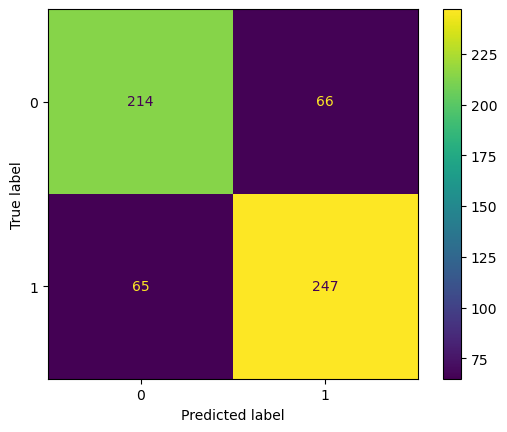

In [123]:
# confusion matrix shown
cm = confusion_matrix(y_test, estimates)
ConfusionMatrixDisplay.from_predictions(y_test, estimates)

### 4.2 KNN Using Purposefully Selected Variables

#### Step 1: Modify Dataset - Drop 'ClosePrice'

In [124]:
X_train2 = X_train.drop(columns=['ClosePrice'])
X_test2 = X_test.drop(columns=['ClosePrice'])

In [125]:
# Build a new pipeline based on selected variables
numeric_features2 = ["SellerRating",
                    "Duration",
                    "OpenPrice"]
categorical_features2 = ["Category",
                        "EndDay"]

numeric_transformer2 = StandardScaler()
categorical_transformer2 = OneHotEncoder(sparse_output = False)

preprocessor2 = make_column_transformer(
    (numeric_transformer2, numeric_features2),
    (categorical_transformer2, categorical_features2)
)

preprocessor2

,transformers,"[('standardscaler', ...), ('onehotencoder', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


#### Step 2: Scale X variables

In [126]:
X_train2_transformed = preprocessor2.fit_transform(X_train2)
X_test2_transformed = preprocessor2.transform(X_test2)

#### Step 3: KNN and Cross Validation

In [127]:
model = KNeighborsClassifier()
kfold = KFold(n_splits = num_folds, shuffle = True, random_state = 8413)

In [128]:
cv_results = cross_val_score(model, X_train2_transformed, y_train, cv = kfold, scoring = scoring_metric)
msg = "KNN: %f (%f)" % (cv_results.mean(), cv_results.std())

print(msg)
print(cv_results)

KNN: 0.668841 (0.035948)
[0.73188406 0.6884058  0.65217391 0.65217391 0.64492754 0.65217391
 0.65217391 0.68115942 0.60869565 0.72463768]


In [129]:
# Grid search
k_values = np.arange(1,22)

param_grid = dict(n_neighbors = k_values)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = scoring_metric, cv = kfold)
grid_results = grid.fit(X_train2_transformed, y_train)
print("Best: %f using %s" % (grid_results.best_score_, grid_results.best_params_))

Best: 0.679710 using {'n_neighbors': np.int64(12)}


In [130]:
# Show all grid search results
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

0.653623 (0.038861) with: {'n_neighbors': np.int64(1)}
0.652899 (0.031495) with: {'n_neighbors': np.int64(2)}
0.661594 (0.033373) with: {'n_neighbors': np.int64(3)}
0.657246 (0.051347) with: {'n_neighbors': np.int64(4)}
0.668841 (0.035948) with: {'n_neighbors': np.int64(5)}
0.674638 (0.049089) with: {'n_neighbors': np.int64(6)}
0.669565 (0.035381) with: {'n_neighbors': np.int64(7)}
0.662319 (0.038372) with: {'n_neighbors': np.int64(8)}
0.673913 (0.036232) with: {'n_neighbors': np.int64(9)}
0.673188 (0.030821) with: {'n_neighbors': np.int64(10)}
0.678986 (0.028995) with: {'n_neighbors': np.int64(11)}
0.679710 (0.023770) with: {'n_neighbors': np.int64(12)}
0.674638 (0.021361) with: {'n_neighbors': np.int64(13)}
0.665942 (0.033120) with: {'n_neighbors': np.int64(14)}
0.663043 (0.032929) with: {'n_neighbors': np.int64(15)}
0.661594 (0.029533) with: {'n_neighbors': np.int64(16)}
0.655797 (0.022972) with: {'n_neighbors': np.int64(17)}
0.655072 (0.023188) with: {'n_neighbors': np.int64(18)}
0

Text(0, 0.5, 'Accuracy')

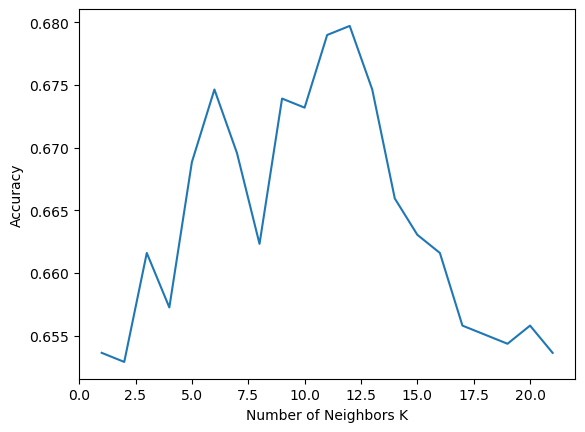

In [131]:
plt.plot(k_values, means)
plt.xlabel("Number of Neighbors K")
plt.ylabel("Accuracy")

#### Step 4: Results on Test Data

In [132]:
model = KNeighborsClassifier(n_neighbors = 12)
model.fit(X_train2_transformed, y_train)
estimates2 = model.predict(X_test2_transformed)

print(accuracy_score(y_test, estimates2))
model.get_params()

0.6722972972972973


{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 12,
 'p': 2,
 'weights': 'uniform'}

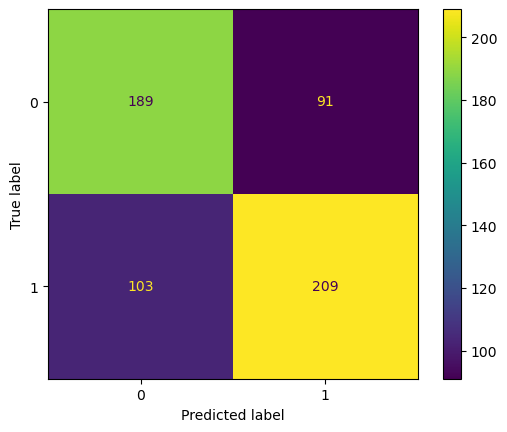

In [133]:
# confusion matrix
cm = confusion_matrix(y_test, estimates2)
ConfusionMatrixDisplay.from_predictions(y_test, estimates2)

## 5. Decision Tree

### 5.1 Decision Tree Part I

#### Step 1: Tunning the hyper-parameter for decision tree

In [134]:
pipe_dt_tune = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(min_samples_leaf = 50, random_state = 8413)
)

param_grid = {
    "decisiontreeclassifier__max_depth": [1, 3, 5, 7, 10]
}

gs_dt = GridSearchCV(
    pipe_dt_tune,
    param_grid = param_grid,
    n_jobs = -1,
    scoring = scoring_metric,
    cv = num_folds
)

gs_dt.fit(X_train, y_train)
print(gs_dt.best_params_)
print("Best accuracy:", gs_dt.best_score_)

{'decisiontreeclassifier__max_depth': 7}
Best accuracy: 0.8239130434782609


#### Step 2: Fit the tree with the tunned hyper-parameter

In [135]:
pipe_dt_best = make_pipeline(preprocessor, DecisionTreeClassifier(max_depth = 7, min_samples_leaf = 50, random_state = 8413))
pipe_dt_best.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('decisiontreeclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('standardscaler', ...), ('onehotencoder', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


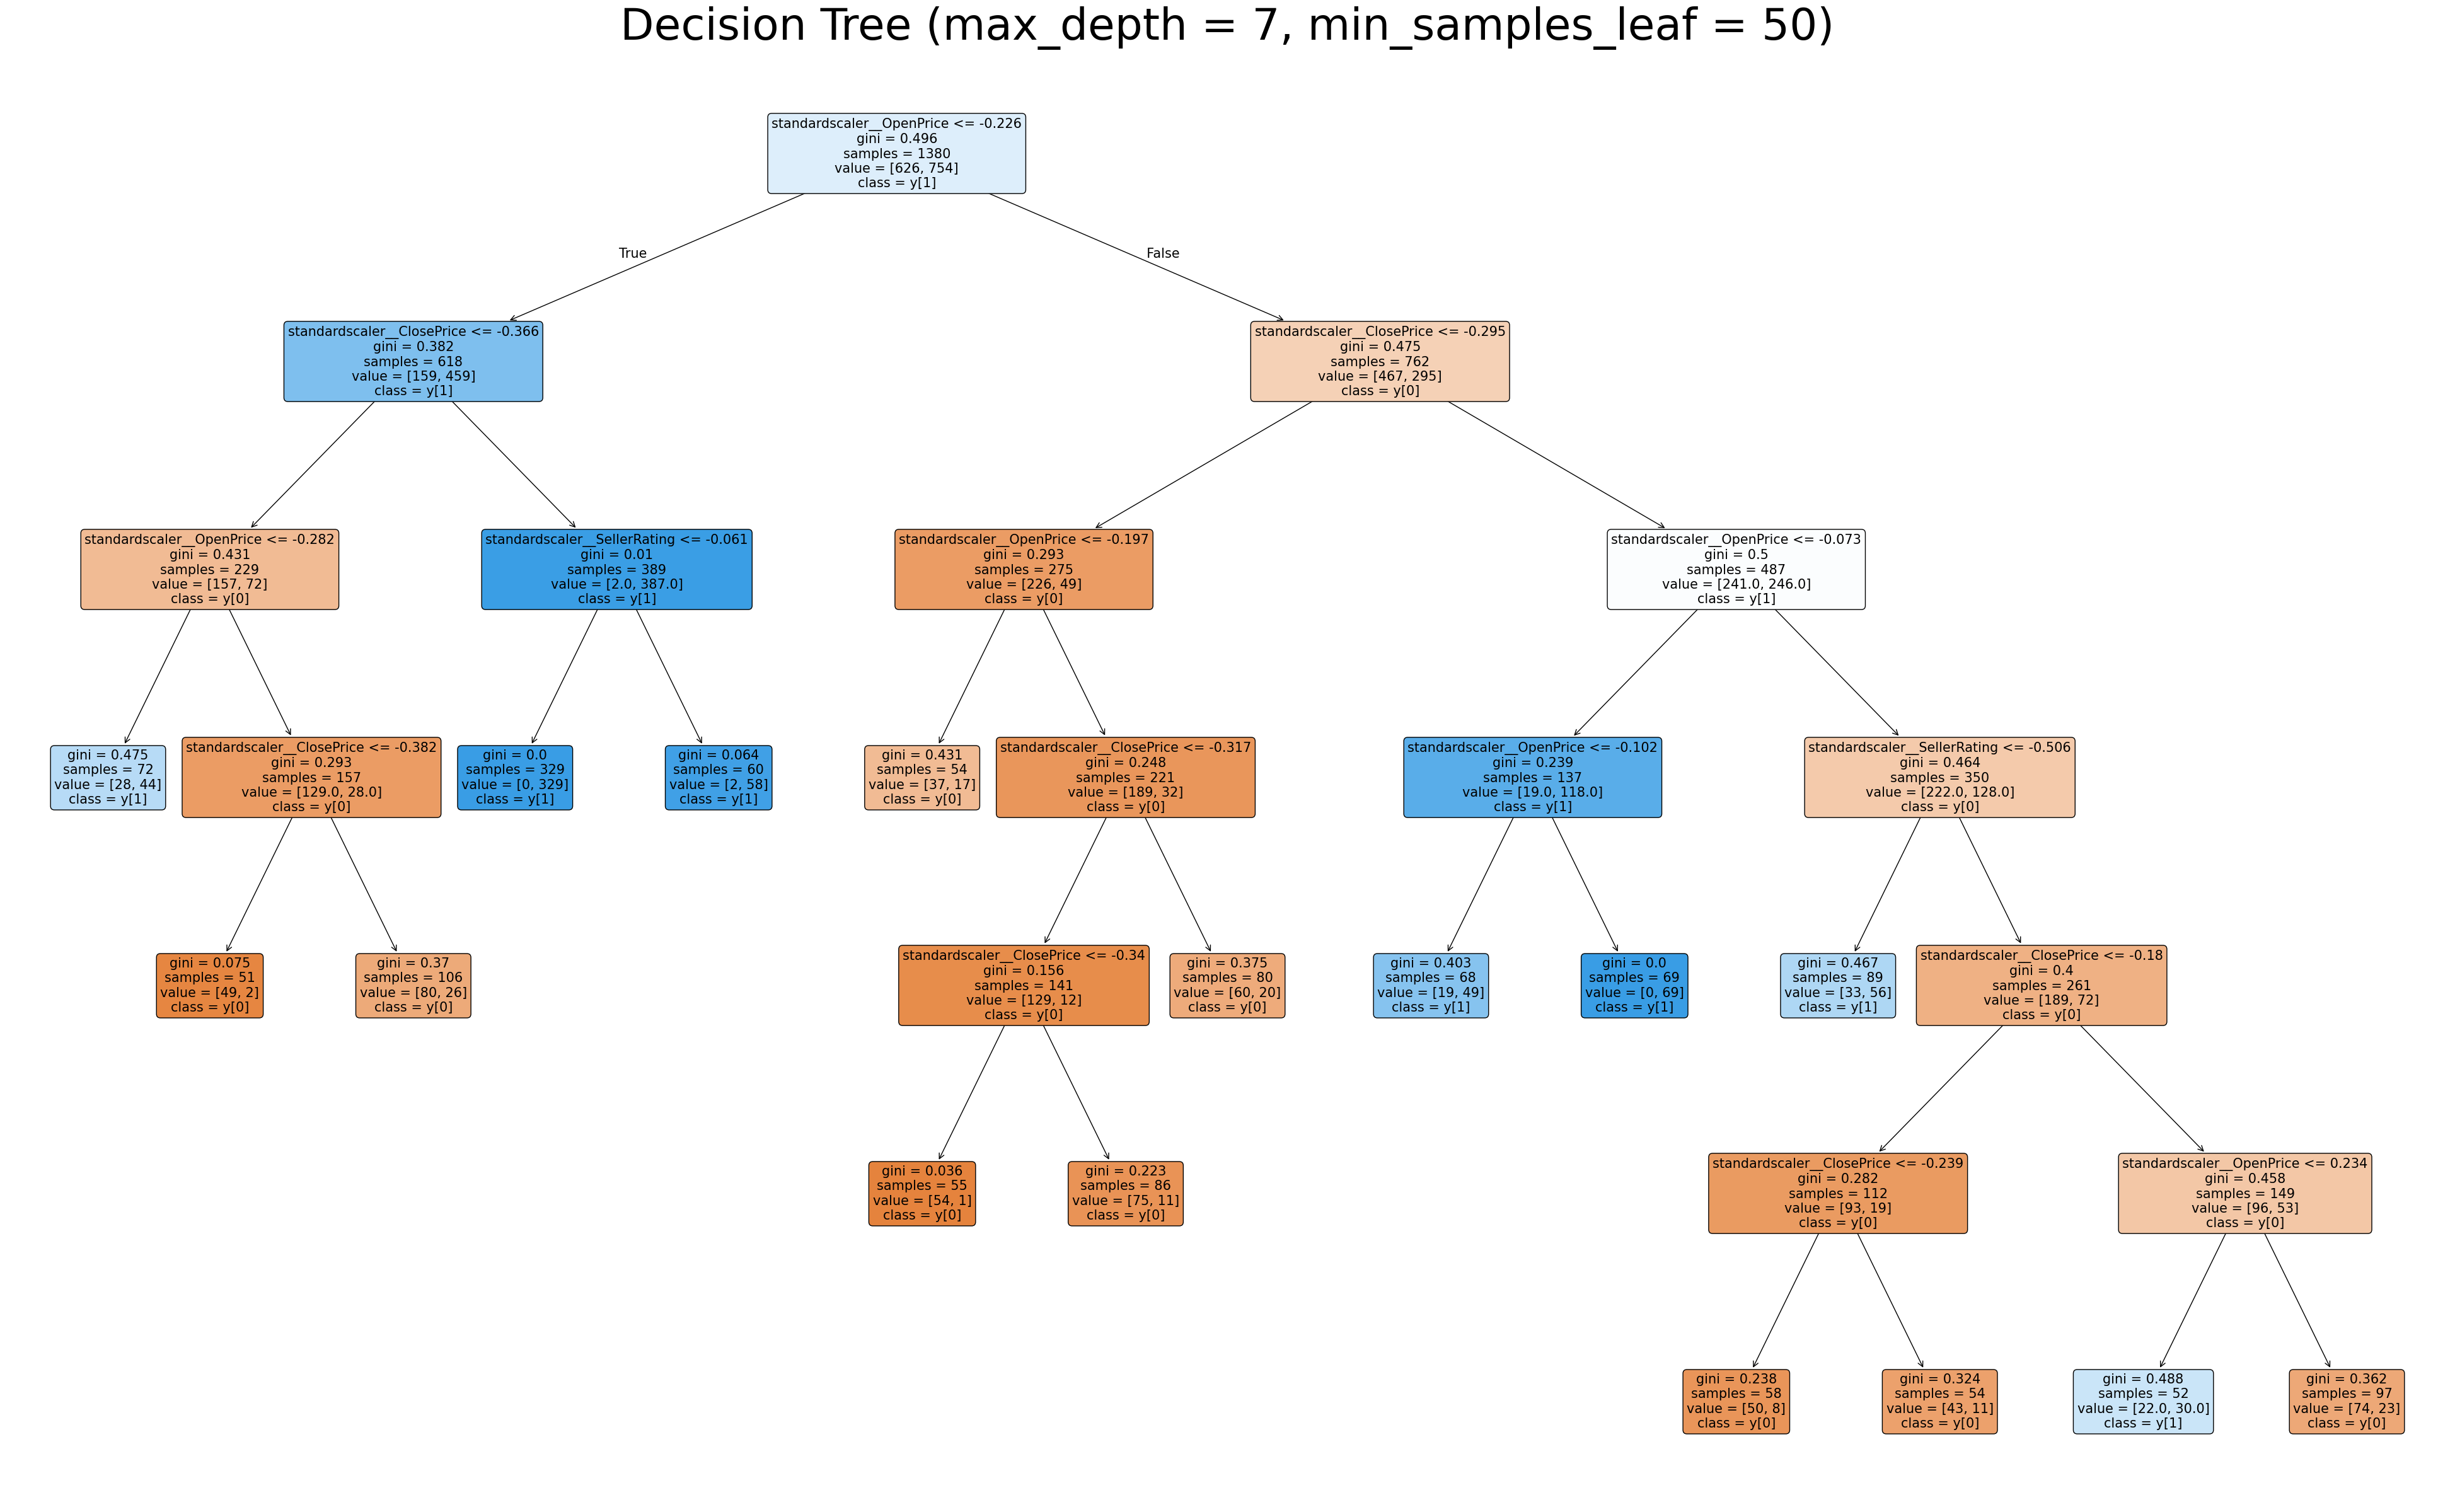

In [136]:
dt_model_best = pipe_dt_best.named_steps['decisiontreeclassifier']

plt.figure(figsize = (50, 30))  
plot_tree(
    dt_model_best,
    filled = True,
    feature_names = preprocessor.get_feature_names_out(),
    class_names = True,  
    rounded = True,
    fontsize = 15
)
plt.title("Decision Tree (max_depth = 7, min_samples_leaf = 50)", fontsize = 50)
plt.show()

#### Step 3: Results on the test set

In [137]:
test_score = pipe_dt_best.score(X_test, y_test)    # score: use accuracy as the default metric
print("Accuracy of decision tree on the test set:", test_score)

Accuracy of decision tree on the test set: 0.8412162162162162


In [138]:
# decide which variables can be removed
importances = dt_model_best.feature_importances_

feature_names = preprocessor.get_feature_names_out()
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feature_importance_df.tail(10))  # least 10 important features

                                         feature  importance
12           onehotencoder__Category_Electronics         0.0
11              onehotencoder__Category_Computer         0.0
10          onehotencoder__Category_Collectibles         0.0
9           onehotencoder__Category_Coins/Stamps         0.0
8   onehotencoder__Category_Clothing/Accessories         0.0
7    onehotencoder__Category_Business/Industrial         0.0
6                  onehotencoder__Category_Books         0.0
5             onehotencoder__Category_Automotive         0.0
4      onehotencoder__Category_Antique/Art/Craft         0.0
28                     onehotencoder__EndDay_Wed         0.0


### 5.2 Decision Tree Part II: Refitting with only Practical Predictors

#### Main Task 1: Calculate the test error rate

##### Step 1: Select only practical predictors & Rebuild the pipeline 

In [139]:
X_train_prac = X_train.drop(columns=['ClosePrice'])
X_test_prac = X_test.drop(columns=['ClosePrice'])

In [140]:
num_prac = ["SellerRating", "Duration", "OpenPrice"]
cat_prac = ["Category", "EndDay"]

In [141]:
preproc_prac = make_column_transformer(
    (StandardScaler(), num_prac),
    (OneHotEncoder(sparse_output=False), cat_prac)
)

pipe_dt_prac = make_pipeline(
    preproc_prac,
    DecisionTreeClassifier(min_samples_leaf=50, random_state=8413)
)

##### Step 2: Hyperparameter tunning

In [142]:
param_grid = {
    "decisiontreeclassifier__max_depth": [1, 3, 5, 7, 10]
}

grid_dt_prac = GridSearchCV(
    pipe_dt_prac,
    param_grid = param_grid,
    cv = num_folds,
    scoring = scoring_metric,
    n_jobs = -1
)

grid_dt_prac.fit(X_train_prac, y_train)

print(grid_dt_prac.best_params_)
print("Best accuracy:", grid_dt_prac.best_score_)

{'decisiontreeclassifier__max_depth': 5}
Best accuracy: 0.7079710144927536


##### Step 3: Fit the tree with the tunned hyper-parameter

In [143]:
pipe_dt_prac_best = make_pipeline(preproc_prac, DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 50, random_state = 8413))
pipe_dt_prac_best.fit(X_train_prac, y_train)

,steps,"[('columntransformer', ...), ('decisiontreeclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('standardscaler', ...), ('onehotencoder', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


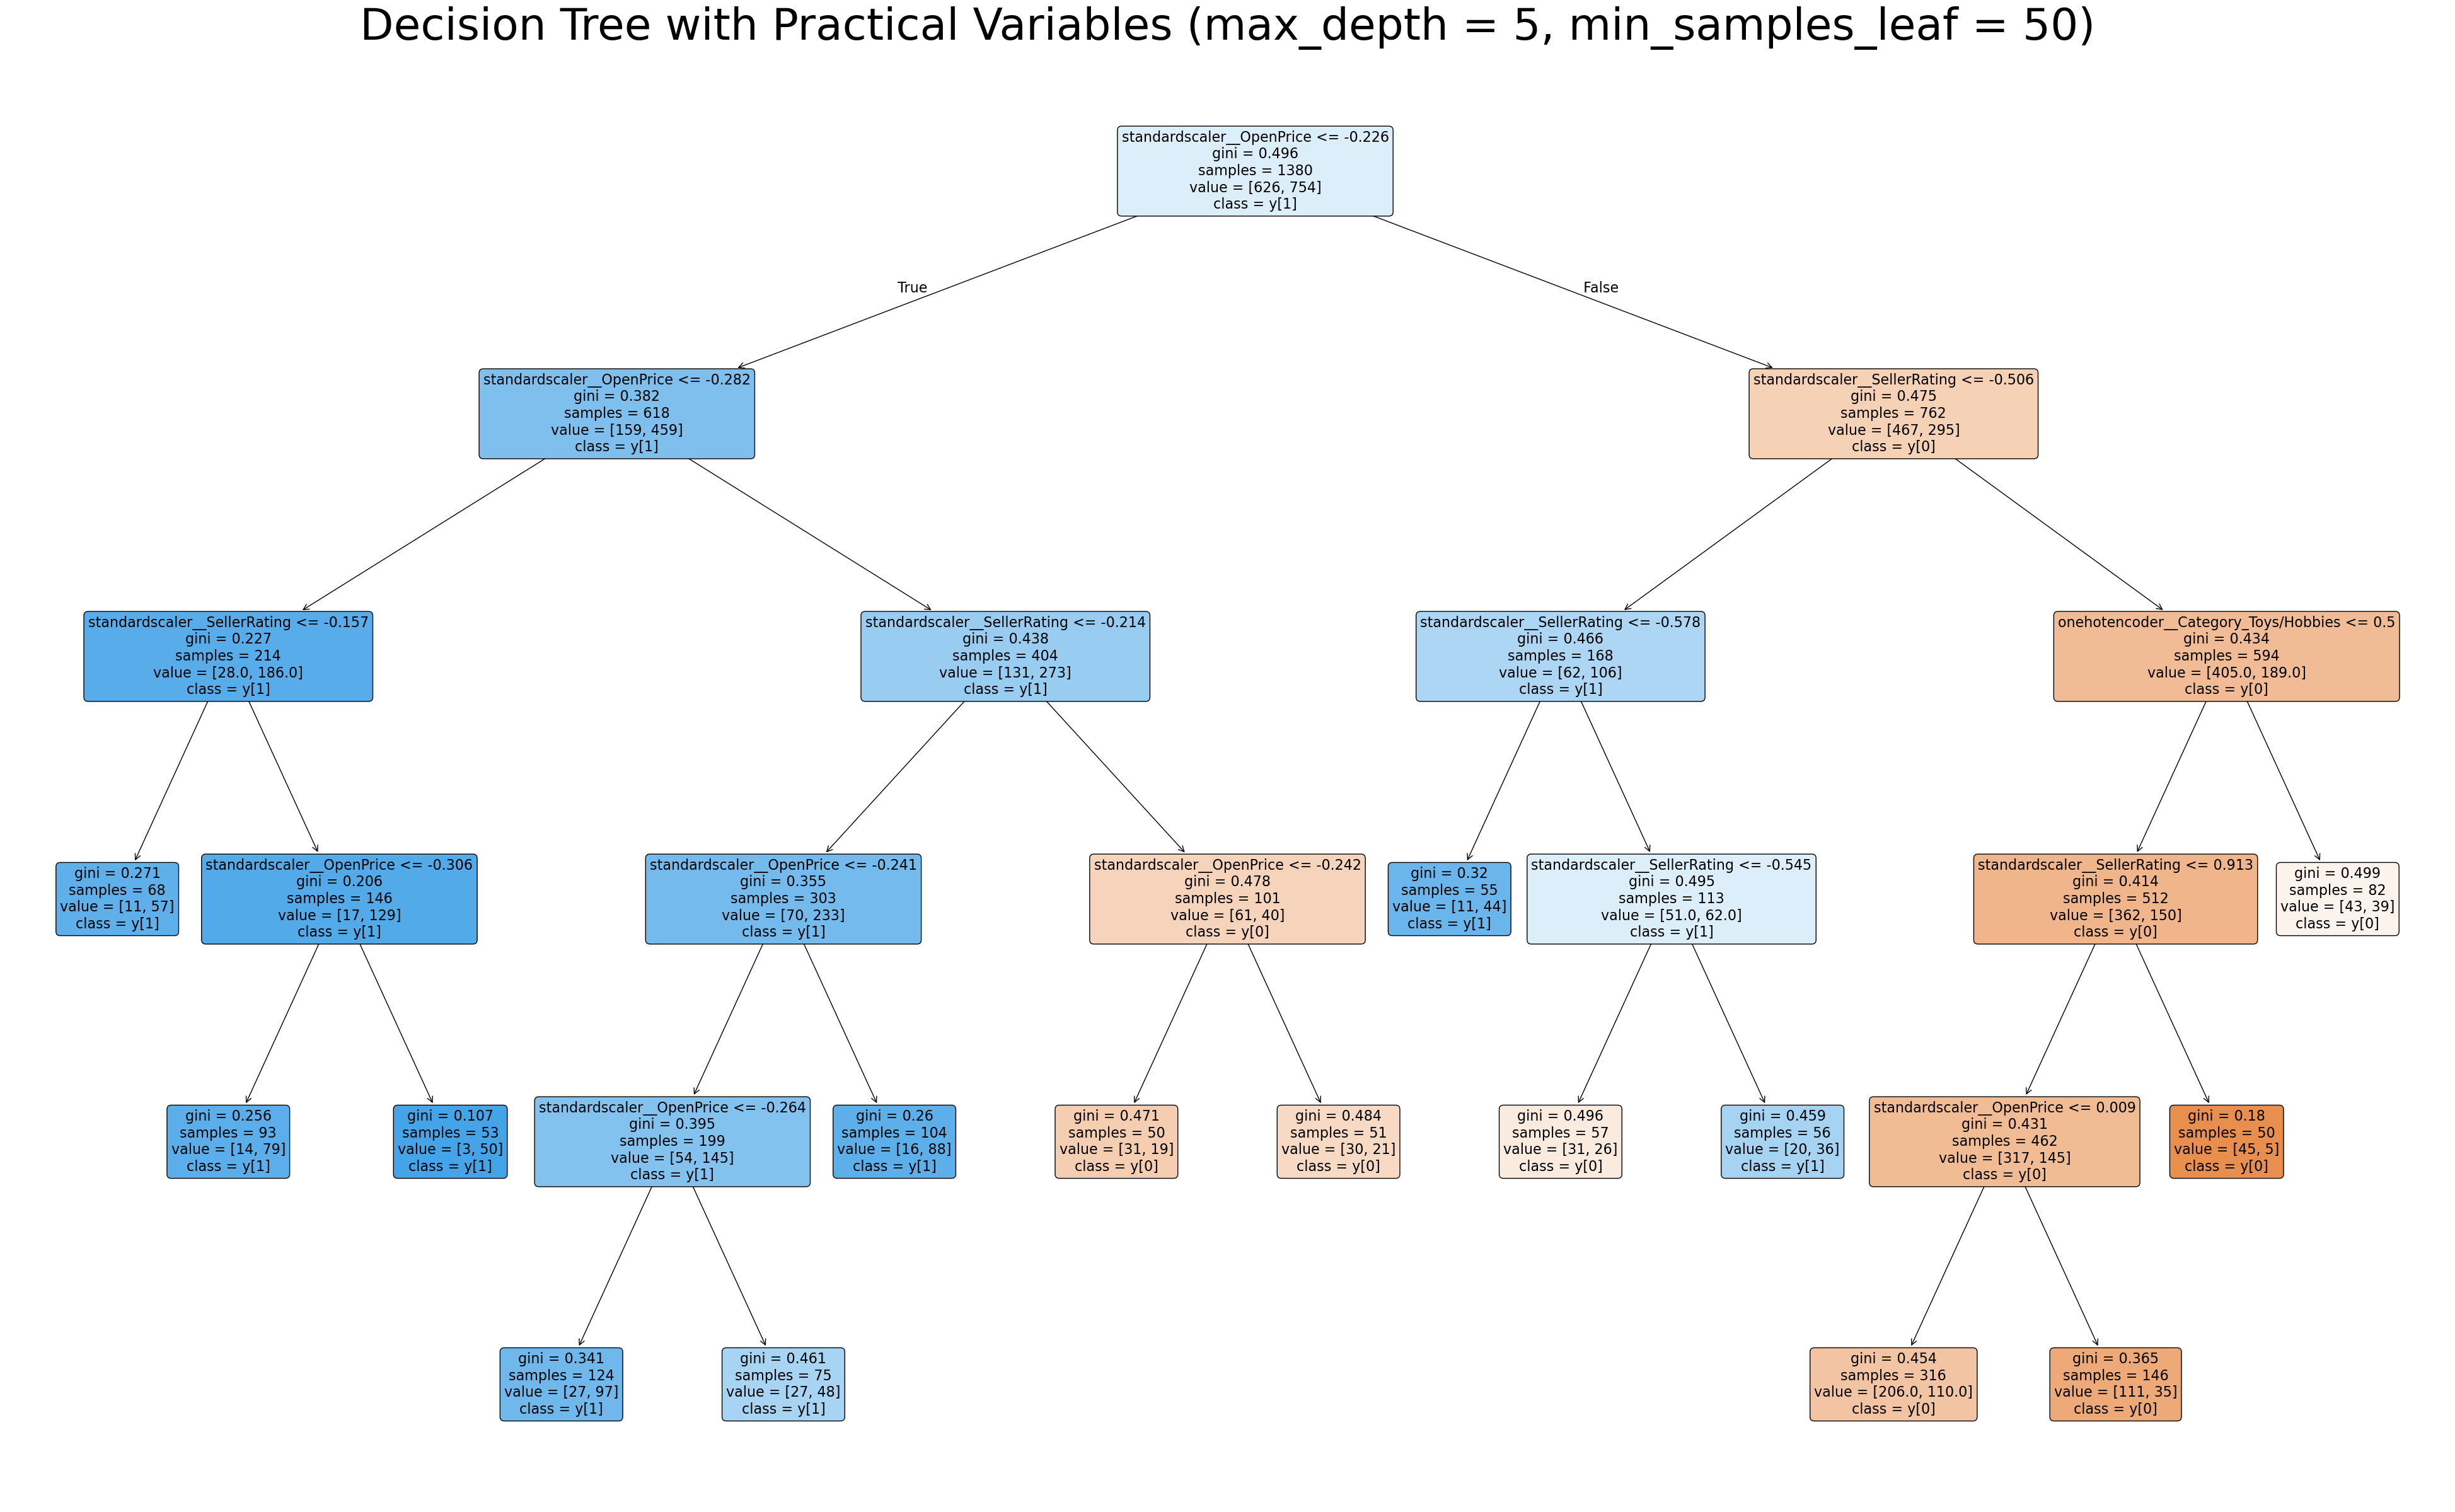

In [144]:
dt_prac_model_best = pipe_dt_prac_best.named_steps['decisiontreeclassifier']

plt.figure(figsize = (50, 30))  
plot_tree(
    dt_prac_model_best,
    filled = True,
    feature_names = preproc_prac.get_feature_names_out(),
    class_names = True,  
    rounded = True,
    fontsize = 16
)
plt.title("Decision Tree with Practical Variables (max_depth = 5, min_samples_leaf = 50)", fontsize = 50)
plt.show()

##### Step 4: Results on the test set

In [145]:
test_score_prac = pipe_dt_prac_best.score(X_test_prac, y_test)   
print("Accuracy of decision tree on the test set:", test_score_prac)

Accuracy of decision tree on the test set: 0.722972972972973


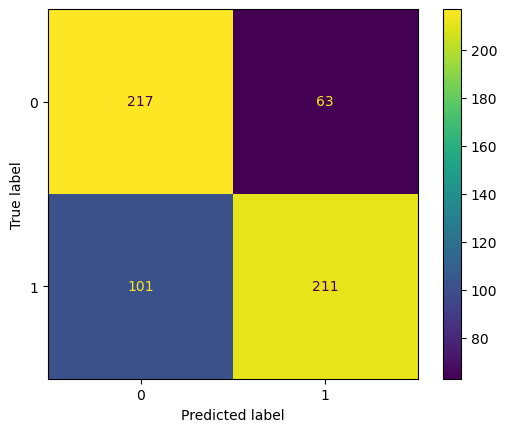

In [146]:
# confusion matrix
y_prac_pred = pipe_dt_prac_best.predict(X_test_prac)

cm = confusion_matrix(y_test, y_prac_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_prac_pred)

#### Main Task 2: Plot the trained tree on a scatter plot 

- Axes are the most two important numerical variables
- It is on the entire dataset (both trained dataset and test dataset)

In [147]:
# deciding which two numerical variables are most important
importances_prac = dt_prac_model_best.feature_importances_

feature_names_prac = preproc_prac.get_feature_names_out()
feature_importance_prac_df = pd.DataFrame({
    'feature': feature_names_prac,
    'importance': importances_prac
}).sort_values(by='importance', ascending=False)

feature_importance_prac_df.head(5)

,feature,importance
2,standardscaler__OpenPrice,0.624050
0,standardscaler__SellerRating,0.347526
20,onehotencoder__Category_Toys/Hobbies,0.028424
15,onehotencoder__Category_Jewelry,0.000000
26,onehotencoder__EndDay_Tue,0.000000


In [148]:
# Based on the above gini importance, OpenPrice and SellerRating seems to be the most 2 important
# numerical features we should use as axes to draw the scatter plot

x_var = feature_importance_prac_df['feature'].head(2).tolist()[0]
y_var = feature_importance_prac_df['feature'].head(2).tolist()[1]
print(x_var)
print(y_var)

standardscaler__OpenPrice
standardscaler__SellerRating


In [149]:
X_ebay_prac = ebay.drop(columns=['Competitive', 'ClosePrice'])
y_ebay = ebay['Competitive']

# recall that preproc_prac is the first half of the pipeline: used to standardize
# and one-hot encode predictors
# preproc_prac = pipe_dt_prac_best.named_steps['columntransformer']
feature_names = preproc_prac.get_feature_names_out()

X_transformed = preproc_prac.transform(X_ebay_prac)
X_transformed_df = pd.DataFrame(X_transformed, columns = feature_names)
X_transformed_df.head()

,standardscaler__SellerRating,standardscaler__Duration,standardscaler__OpenPrice,onehotencoder__Category_Antique/Art/Craft,onehotencoder__Category_Automotive,onehotencoder__Category_Books,onehotencoder__Category_Business/Industrial,onehotencoder__Category_Clothing/Accessories,onehotencoder__Category_Coins/Stamps,onehotencoder__Category_Collectibles,...,onehotencoder__Category_Pottery/Glass,onehotencoder__Category_SportingGoods,onehotencoder__Category_Toys/Hobbies,onehotencoder__EndDay_Fri,onehotencoder__EndDay_Mon,onehotencoder__EndDay_Sat,onehotencoder__EndDay_Sun,onehotencoder__EndDay_Thu,onehotencoder__EndDay_Tue,onehotencoder__EndDay_Wed
0,-0.073206,-0.727443,-0.311356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.073206,-0.727443,-0.311356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.073206,-0.727443,-0.311356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.073206,-0.727443,-0.311356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.073206,-0.727443,-0.311356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


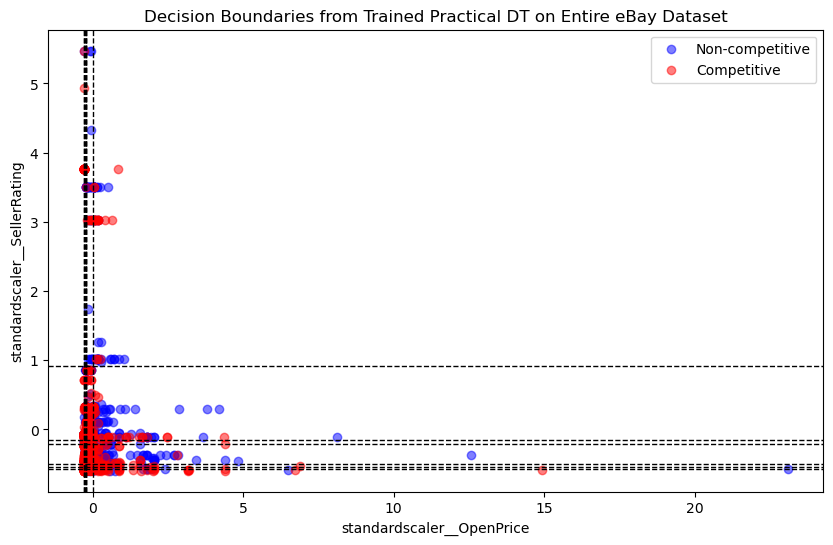

In [150]:
plt.figure(figsize=(10, 6))

plt.scatter(
    X_transformed_df.loc[y_ebay == 0, x_var],
    X_transformed_df.loc[y_ebay == 0, y_var],
    color = 'blue', alpha = 0.5, label = 'Non-competitive'
)

plt.scatter(
    X_transformed_df.loc[y_ebay == 1, x_var],
    X_transformed_df.loc[y_ebay == 1, y_var],
    color = 'red', alpha = 0.5, label = 'Competitive'
)

plt.xlabel(x_var)
plt.ylabel(y_var)
plt.legend()
plt.title('Decision Boundaries from Trained Practical DT on Entire eBay Dataset')

n_nodes = dt_prac_model_best.tree_.node_count
feature = dt_prac_model_best.tree_.feature
threshold = dt_prac_model_best.tree_.threshold

# loop through all internal nodes and root node to store all split conditions/thresholds 
# if that node uses our x-axis or y-axis variable
# So basically, it collects all decision boundaries that occur those two predictors
split_lines_x = []
split_lines_y = []

for i in range(n_nodes):
    if feature[i] != -2:  # skip leaves
        f_name = feature_names[feature[i]]
        if f_name == x_var:
            split_lines_x.append(threshold[i])
        elif f_name == y_var:
            split_lines_y.append(threshold[i])

# draw the split lines
for val in split_lines_x:
    plt.axvline(x=val, color='black', linestyle='--', linewidth=1)

for val in split_lines_y:
    plt.axhline(y=val, color='black', linestyle='--', linewidth=1)

plt.show()

# since we have scaled both numerical variables, 
# it could be a bit harder to interpret whether this split makes sense
# by looking at their scaled values


In [151]:
# print out those above split conditions for explanation purpose in the report

# Find the feature indices
x_index = list(feature_names).index(x_var)
y_index = list(feature_names).index(y_var)

# Loop through all nodes
# n_nodes = dt_prac_model_best.tree_.node_count
for i in range(n_nodes):
    if dt_prac_model_best.tree_.feature[i] != -2:  
        feature_index = dt_prac_model_best.tree_.feature[i]
        threshold_val = dt_prac_model_best.tree_.threshold[i]
        
        # Only show splits for x_var and y_var
        if feature_index in [x_index, y_index]:
            print(f"Node {i}: {feature_names[feature_index]} <= {threshold_val:.3f}")

Node 0: standardscaler__OpenPrice <= -0.226
Node 1: standardscaler__OpenPrice <= -0.282
Node 2: standardscaler__SellerRating <= -0.157
Node 4: standardscaler__OpenPrice <= -0.306
Node 7: standardscaler__SellerRating <= -0.214
Node 8: standardscaler__OpenPrice <= -0.241
Node 9: standardscaler__OpenPrice <= -0.264
Node 13: standardscaler__OpenPrice <= -0.242
Node 16: standardscaler__SellerRating <= -0.506
Node 17: standardscaler__SellerRating <= -0.578
Node 19: standardscaler__SellerRating <= -0.545
Node 23: standardscaler__SellerRating <= 0.913
Node 24: standardscaler__OpenPrice <= 0.009
